# **1. Objective**
To **classify** different types of rice using **Transfer Learning**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 

from sklearn.model_selection import train_test_split

import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input, MaxPooling2D,GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import EfficientNetB0, VGG16

import warnings
warnings.filterwarnings("ignore") 

plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize']=(20,20)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3

  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **3. Acquiring our Data from the Directories**

In [2]:
fpath = "/kaggle/input/rice-image-dataset/Rice_Image_Dataset"
random_seed = 69

In [3]:
import os

# Specify the path to your dataset
dataset_path = "../input/rice-image-dataset/Rice_Image_Dataset"

# Get a list of subdirectories (each subdirectory corresponds to a class)
class_folders = [f.name for f in os.scandir(dataset_path) if f.is_dir()]

# Get the number of classes
num_classes = len(class_folders)

# Print the number of classes
print("Number of classes:", num_classes)

Number of classes: 5


**Splitting the Data into Train and Validation**

In [4]:
img_size = 224
batch_size =64
fpath = "/kaggle/input/rice-image-dataset/Rice_Image_Dataset"
datagen = ImageDataGenerator(rescale=1/255.,
                             zoom_range=0.2,
                             validation_split = 0.2,
                             rotation_range=30,
                             horizontal_flip=True)

In [5]:
train = datagen.flow_from_directory(fpath,
                                    target_size=(224,224),
                                    subset="training",
                                    class_mode='categorical',
                                    batch_size=batch_size)
valdata = datagen.flow_from_directory(fpath,
                                      target_size=(224,224),
                                      batch_size=64,
                                      subset='validation',
                                      class_mode='categorical')

Found 60000 images belonging to 5 classes.

Found 15000 images belonging to 5 classes.


# **4. Generating Visual Representation of the Training Dataset**

<Figure size 2000x2000 with 0 Axes>

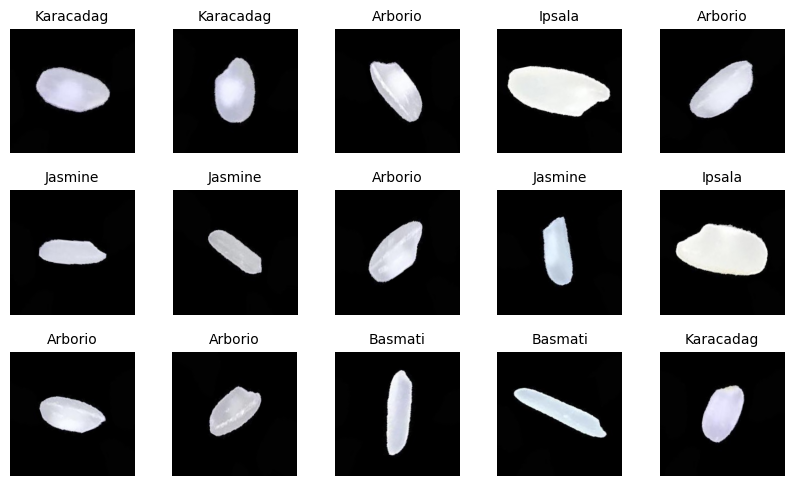

In [6]:
import numpy as np
import matplotlib.pyplot as plt
labels = [k for k in train.class_indices]
sample_generate = train.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))
plt.figure(figsize=(10, 10))

for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(labels[np.argmax(titles[i])].split('-')[-1], fontsize = 10)
    plt.axis("off")

# **5. Applying Transfer Learning using VGG16**
* Has **16 Layers**
* We have used **imagenet** as the dataset on which VGG16 is trained on
* We exclude the top layer so we can add our own layers

In [7]:
img_size = 224
base_model = VGG16(include_top = False,
                       weights = 'imagenet',
                       input_shape = (img_size,img_size,3))


58889256/58889256 [==============================] - 0s 0us/step


In [8]:
#base_model.summary()

**Freezing 4 Layers from the top so we can train the Base Model on our Data**

In [9]:
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [10]:
from tensorflow.keras.optimizers import Adam

**Adding our own layers**

In [11]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))

In [12]:
model.summary()

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 vgg16 (Functional)          (None, 7, 7, 512)         14714688  

                                                                 

 global_average_pooling2d (  (None, 512)               0         

 GlobalAveragePooling2D)                                         

                                                                 

 dense (Dense)               (None, 512)               262656    

                                                                 

 dropout (Dropout)           (None, 512)               0         

                                                                 

 dense_1 (Dense)             (None, 5)                 2565      

                                                                 


Total params: 14979909 (57.14 MB)

Trainable params: 7344645 (28.02 MB)

Non-trainable params: 7635264 (29

In [13]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

**We Implement Checkpoints over here which are very Important for an Efficient Training**
* **ModelCheckpoint** callback is used in conjunction with training using model. fit() to save a model or weights in a checkpoint file at some time, so the model or weights can be loaded later to continue the training from the state saved.
***EarlyStopping** is a method that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset
***ReduceLROnPlateau** adjusts the models Learing Rate dynamically depending on how the model is performing on the validation dataset. The metric to evaluate it's performance is val_loss.

In [15]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

reduce_lr = tf._keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.00000001)

# **6. Training the Model**

In [16]:
try:
    history = model.fit(train,
                        epochs=50,
                        validation_data=valdata,
                        callbacks=[checkpoint, earlystopping, reduce_lr])
except KeyboardInterrupt:
    print("\nTraining Stopped")

Epoch 1/50

938/938 [==============================] - ETA: 0s - loss: 0.1043 - accuracy: 0.9623

Epoch 1: val_loss improved from inf to 0.02687, saving model to model.h5

938/938 [==============================] - 1265s 1s/step - loss: 0.1043 - accuracy: 0.9623 - val_loss: 0.0269 - val_accuracy: 0.9911 - lr: 1.0000e-04

Epoch 2/50

938/938 [==============================] - ETA: 0s - loss: 0.0348 - accuracy: 0.9881

Epoch 2: val_loss improved from 0.02687 to 0.02138, saving model to model.h5

938/938 [==============================] - 990s 1s/step - loss: 0.0348 - accuracy: 0.9881 - val_loss: 0.0214 - val_accuracy: 0.9923 - lr: 1.0000e-04

Epoch 3/50

938/938 [==============================] - ETA: 0s - loss: 0.0291 - accuracy: 0.9904

Epoch 3: val_loss improved from 0.02138 to 0.01031, saving model to model.h5

938/938 [==============================] - 991s 1s/step - loss: 0.0291 - accuracy: 0.9904 - val_loss: 0.0103 - val_accuracy: 0.9966 - lr: 1.0000e-04

Epoch 4/50

938/938 [====

In [17]:
model = tf.keras.models.load_model("/kaggle/working/model.h5")

# **6. Evaluation of the Training of the Model**

**Plot of loss and val_loss**

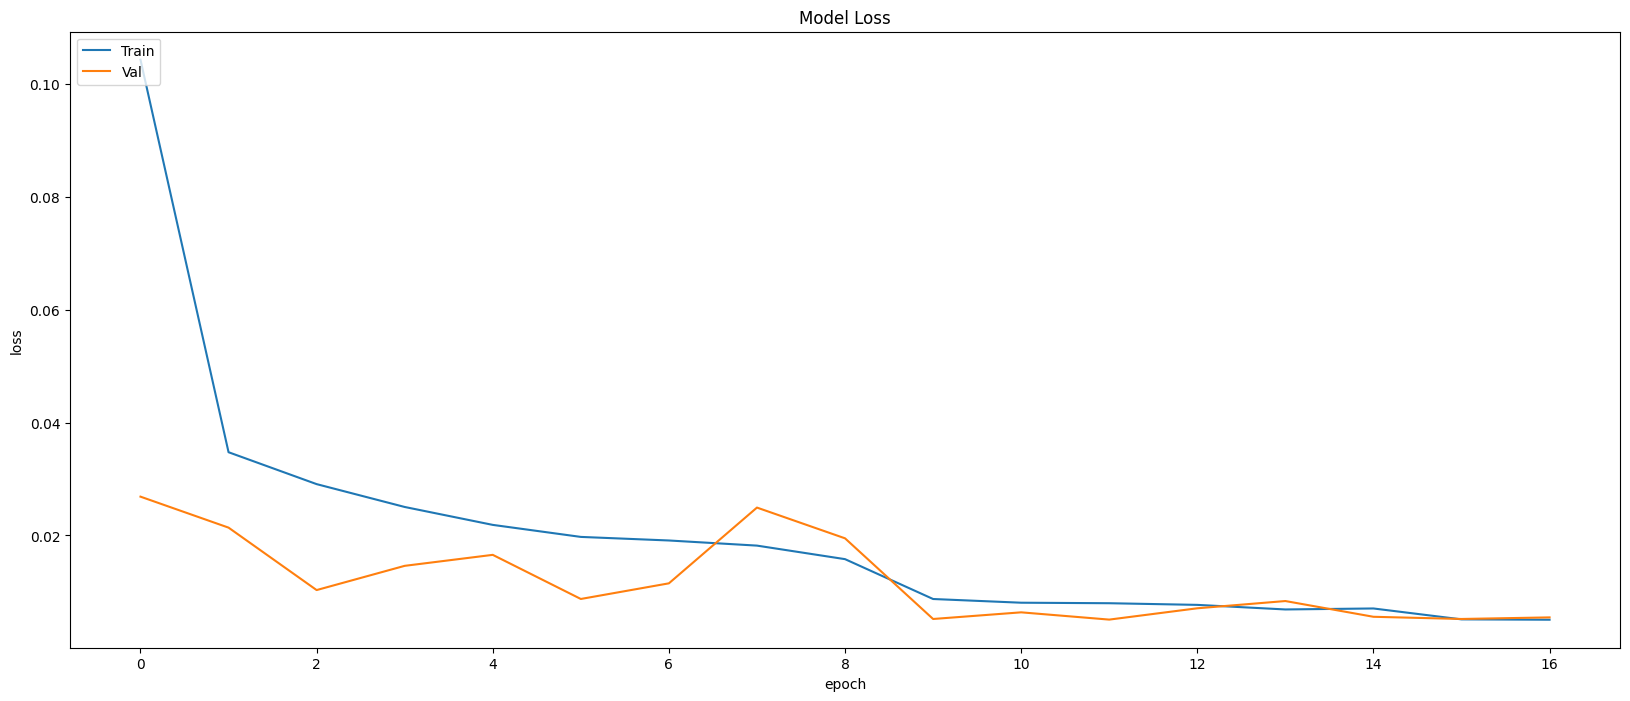

In [18]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
#plot the training loss over every epoch
plt.plot(history.history['val_loss'])
#plot the validation loss
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Val'],loc='upper left')
plt.show()

**Plot of accuracy and val_accuracy**

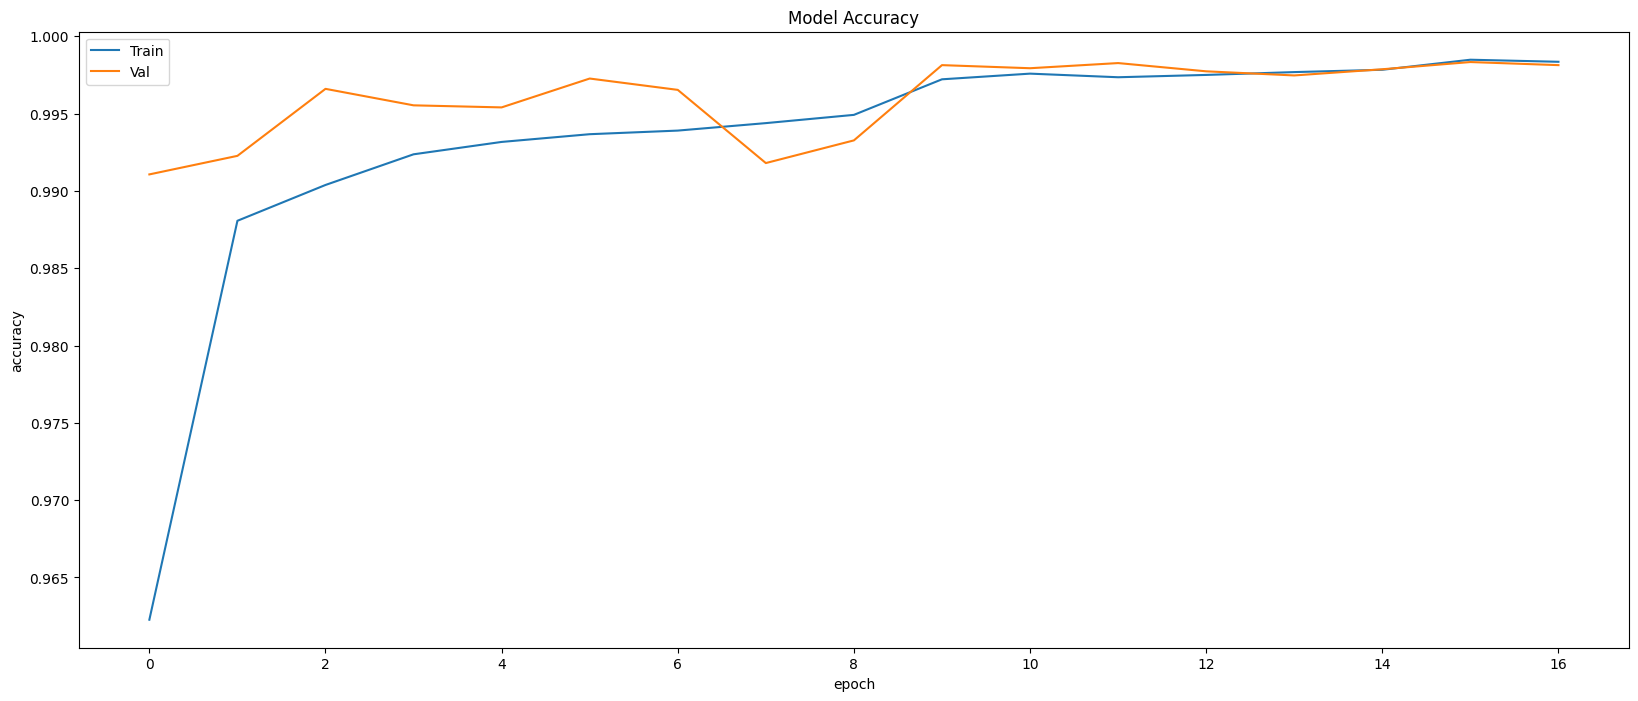

In [19]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
#plot the training accuracy over all the epochs
plt.plot(history.history['val_accuracy'])
#plot the validation accuracy over all the epochs
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Val'],loc='upper left')
plt.show()